In [1]:
import keras
import tensorflow as tf
import glob
from pathlib import Path
from astropy.io import fits
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout
import time

Using TensorFlow backend.


In [2]:
print(tf.__version__)

2.1.0


# DFNN

# CNN

In [3]:
tic = time.perf_counter()
galaxy = np.zeros((40,40))
for filepath in glob.iglob('../Data/npycutouts/galaxyfits/*npy', recursive=True):
    fp = Path(filepath)
    array = np.load(fp)
    galaxy = np.dstack((galaxy,array))
galaxy = galaxy[:,:,1:]
print(galaxy.shape[2])
toc = time.perf_counter()
print(f"Runtime {toc - tic} seconds")

3123
Runtime 24.6516667 seconds


In [4]:
from scipy.ndimage import rotate
galaxy = np.dstack((galaxy, np.rot90(galaxy,1),np.rot90(galaxy,2),np.rot90(galaxy,3)))
galaxy = np.dstack((galaxy,np.flip(galaxy,axis=0)))
print(len(galaxy))

40


In [5]:
print(galaxy.shape)

(40, 40, 24984)


In [12]:
'''
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
    '''

'\ndatagen = ImageDataGenerator(\n    featurewise_center=True,\n    featurewise_std_normalization=True,\n    rotation_range=20,\n    width_shift_range=0.2,\n    height_shift_range=0.2,\n    horizontal_flip=True)\n    '

In [6]:
tic = time.perf_counter()
star = np.zeros((40,40))
count = 0
for filepath in glob.iglob('../Data/npycutouts/starfits/*npy', recursive=True):
    fp = Path(filepath)
    array = np.load(fp)
    star = np.dstack((star,array))
    count += 1
    if count == galaxy.shape[2]:
        break
star = star[:,:,1:]
print(star.shape)
toc = time.perf_counter()
print(f"Runtime {toc - tic} seconds")

(40, 40, 24984)
Runtime 1442.974225 seconds


In [7]:
X = np.dstack((galaxy,star))
y = np.dstack((np.ones((1,1,galaxy.shape[2])),np.zeros((1,1,star.shape[2]))))
print(X.shape)

(40, 40, 49968)


In [8]:
X = np.moveaxis(X, -1, 0)
y = np.moveaxis(y, -1, 0)

In [9]:
print(y.shape)

(49968, 1, 1)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [12]:
X_train = X_train.reshape(len(X_train),40,40,1)
X_test = X_test.reshape(len(X_test),40,40,1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
#create model
model = Sequential()
#add model layers
model.add(Conv2D(16, kernel_size=5, activation='relu', input_shape=(40,40,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='random_normal'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
#Compiling the neural network
model.compile(optimizer ='Adadelta',loss='binary_crossentropy', metrics =['accuracy'])
#Fitting the data to the training dataset
model.fit(X_train,y_train, batch_size=32, epochs=1024, shuffle=True, use_multiprocessing=True)

In [22]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
#create model
model = Sequential()
#add model layers
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(40,40,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Conv2D(32, kernel_size=5, activation='relu',strides=(2,2)))
model.add(Dropout(0.4))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(Conv2D(64, kernel_size=5, activation='relu',strides=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='random_normal'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
#Compiling the neural network
model.compile(optimizer =optimizers.Adam(amsgrad=True),loss='binary_crossentropy', metrics =['accuracy'])
#Fitting the data to the training dataset
history = model.fit(X_train,y_train, batch_size=32, epochs=1024, shuffle=True, use_multiprocessing=True)

Epoch 1/1024
39974/39974 [==============================] - 9s 231us/step - loss: 1.5506 - accuracy: 0.7639
Epoch 2/1024
39974/39974 [==============================] - 7s 178us/step - loss: 0.4152 - accuracy: 0.8174
Epoch 3/1024
39974/39974 [==============================] - 7s 182us/step - loss: 0.3859 - accuracy: 0.8321
Epoch 4/1024
39974/39974 [==============================] - 7s 169us/step - loss: 0.3650 - accuracy: 0.8453
Epoch 5/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.3509 - accuracy: 0.8518
Epoch 6/1024
39974/39974 [==============================] - 7s 179us/step - loss: 0.3380 - accuracy: 0.8594
Epoch 7/1024
39974/39974 [==============================] - 7s 180us/step - loss: 0.3288 - accuracy: 0.8644
Epoch 8/1024
39974/39974 [==============================] - 7s 173us/step - loss: 0.3164 - accuracy: 0.8708
Epoch 9/1024
39974/39974 [==============================] - 7s 175us/step - loss: 0.3055 - accuracy: 0.8758
Epoch 10/1024
39974/39974 [=

39974/39974 [==============================] - 7s 172us/step - loss: 0.1103 - accuracy: 0.9615
Epoch 151/1024
39974/39974 [==============================] - 7s 173us/step - loss: 0.1131 - accuracy: 0.9607
Epoch 152/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.1120 - accuracy: 0.9612
Epoch 153/1024
39974/39974 [==============================] - 7s 175us/step - loss: 0.1137 - accuracy: 0.9599
Epoch 154/1024
39974/39974 [==============================] - 7s 173us/step - loss: 0.1095 - accuracy: 0.9602
Epoch 155/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.1099 - accuracy: 0.9618
Epoch 156/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.1098 - accuracy: 0.9615
Epoch 157/1024
39974/39974 [==============================] - 7s 173us/step - loss: 0.1084 - accuracy: 0.9624
Epoch 158/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.1114 - accuracy: 0.9614
Epoch 159/1024
39974/3997

39974/39974 [==============================] - 7s 172us/step - loss: 0.0784 - accuracy: 0.9718
Epoch 299/1024
39974/39974 [==============================] - 7s 173us/step - loss: 0.0804 - accuracy: 0.9710
Epoch 300/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0768 - accuracy: 0.9729
Epoch 301/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0809 - accuracy: 0.9712
Epoch 302/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0787 - accuracy: 0.9723
Epoch 303/1024
39974/39974 [==============================] - 7s 173us/step - loss: 0.0773 - accuracy: 0.9723
Epoch 304/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0745 - accuracy: 0.9736
Epoch 305/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0777 - accuracy: 0.9720
Epoch 306/1024
39974/39974 [==============================] - 7s 173us/step - loss: 0.0920 - accuracy: 0.9671
Epoch 307/1024
39974/3997

39974/39974 [==============================] - 7s 172us/step - loss: 0.0618 - accuracy: 0.9776
Epoch 447/1024
39974/39974 [==============================] - 7s 171us/step - loss: 0.0608 - accuracy: 0.9776
Epoch 448/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0591 - accuracy: 0.9775
Epoch 449/1024
39974/39974 [==============================] - 7s 173us/step - loss: 0.0603 - accuracy: 0.9772
Epoch 450/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0595 - accuracy: 0.9782
Epoch 451/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0594 - accuracy: 0.9771
Epoch 452/1024
39974/39974 [==============================] - 7s 171us/step - loss: 0.0598 - accuracy: 0.9777
Epoch 453/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0578 - accuracy: 0.9780
Epoch 454/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0579 - accuracy: 0.9779
Epoch 455/1024
39974/3997

39974/39974 [==============================] - 7s 172us/step - loss: 0.0506 - accuracy: 0.9813
Epoch 595/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0535 - accuracy: 0.9801
Epoch 596/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0482 - accuracy: 0.9818
Epoch 597/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0513 - accuracy: 0.9803
Epoch 598/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0507 - accuracy: 0.9810
Epoch 599/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0517 - accuracy: 0.9801
Epoch 600/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0474 - accuracy: 0.9822
Epoch 601/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0541 - accuracy: 0.9805
Epoch 602/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0516 - accuracy: 0.9800
Epoch 603/1024
39974/3997

39974/39974 [==============================] - 7s 172us/step - loss: 0.0405 - accuracy: 0.9839
Epoch 743/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0404 - accuracy: 0.9845
Epoch 744/1024
39974/39974 [==============================] - 7s 173us/step - loss: 0.0407 - accuracy: 0.9838
Epoch 745/1024
39974/39974 [==============================] - 7s 173us/step - loss: 0.0432 - accuracy: 0.9828
Epoch 746/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0432 - accuracy: 0.9826
Epoch 747/1024
39974/39974 [==============================] - 7s 171us/step - loss: 0.0428 - accuracy: 0.9832
Epoch 748/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0439 - accuracy: 0.9835
Epoch 749/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0423 - accuracy: 0.9824
Epoch 750/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0395 - accuracy: 0.9842
Epoch 751/1024
39974/3997

39974/39974 [==============================] - 7s 173us/step - loss: 0.0372 - accuracy: 0.9856
Epoch 891/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0386 - accuracy: 0.9847
Epoch 892/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0355 - accuracy: 0.9854
Epoch 893/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0377 - accuracy: 0.9846
Epoch 894/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0369 - accuracy: 0.9851
Epoch 895/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0404 - accuracy: 0.9842
Epoch 896/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0375 - accuracy: 0.9852
Epoch 897/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0370 - accuracy: 0.9851
Epoch 898/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0381 - accuracy: 0.9849
Epoch 899/1024
39974/3997

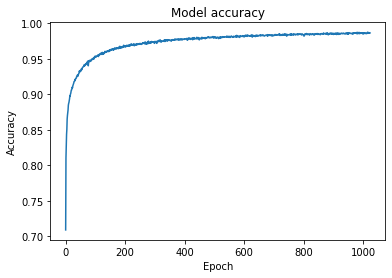

In [30]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt 
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig('../Figures/CNN_accuracy_augment.png')
plt.show()

In [24]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 38, 38, 32)        320       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 36, 36, 32)        9248      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 32)        25632     
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 4, 4, 64)         

In [32]:
from keras.utils import plot_model
plot_model(model, to_file='../Figure/CNN_model_augment.png')

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [33]:
eval_model=model.evaluate(X_train, y_train)
eval_model
y_pred=model.predict(X_test)
y_pred =(y_pred>0.5)

39974/39974 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 61us/step


In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[4767  237]
 [ 351 4639]]


In [35]:
print(cm[0,1])

237


In [36]:
def MCC(matrix):
    '''
    Calcualtes the Matthews Correlation Coefficient from a confusion matrix
    '''
    return ((matrix[0,0]*matrix[1,1])-(matrix[1,0]*matrix[0,1]))/np.sqrt((cm[0,0]+cm[1,0])*(cm[0,0]+cm[0,1])*(cm[1,1]+cm[1,0])*(cm[1,1]+cm[0,1]))

In [37]:
print("Error Rate:"+'{:.3%}'.format((cm[0,1]+cm[1,0])/np.sum(cm)))
print("Accuracy:"+'{:.3%}'.format((cm[0,0]+cm[1,1])/np.sum(cm)))
print("Sensitivity:"+'{:.3%}'.format((cm[0,0])/np.sum(cm[0,:])))
print("Specificity :"+'{:.3%}'.format((cm[1,1])/np.sum(cm[1,:])))
print("Precision:"+'{:.3%}'.format((cm[0,0])/np.sum(cm[:,0])))
print("False Positive Rate:"+'{:.3%}'.format(1-((cm[1,1])/np.sum(cm[1,:]))))
print("Matthews Correlation Coefficient:"+'{:.3%}'.format(MCC(cm)))

Error Rate:5.884%
Accuracy:94.116%
Sensitivity:95.264%
Specificity :92.966%
Precision:93.142%
False Positive Rate:7.034%
Matthews Correlation Coefficient:88.256%


In [39]:
model.save('../Models/CNN_model_augment.h5')

## Sanity Check

In [ ]:
for filepath in glob.iglob('../Data/cutouts/starfits/*fits', recursive=True):
    fp = Path(filepath)
    hdulist = fits.open(fp)
    scidata = hdulist[0].data
    

In [179]:
filepath = '../Data/cutouts/starfits/starfits-256.fits'
fp = Path(filepath)
hdulist = fits.open(fp)
scidata = hdulist[0].data

In [181]:
# Stars should return 0, galaxies return 1
model.predict(scidata.reshape(1,40,40,1))

array([[0.36742818]], dtype=float32)

In [30]:
tf.__version__

'2.1.0'

In [28]:
print(X)

[[[ 2.66089351e+01  6.08204231e+01  3.04102116e+01 ...  3.04102116e+01
   -4.56153173e+01  5.32178702e+01]
  [-1.52051058e+01 -3.80127645e+00 -3.80127645e+00 ... -3.80127645e+00
   -1.52051058e+01  7.60255289e+00]
  [ 4.18140409e+01 -2.28076587e+01 -3.80127645e+00 ... -7.60255289e+00
    2.28076587e+01  2.28076587e+01]
  ...
  [ 3.42114880e+01 -2.28076587e+01  7.60255289e+01 ... -2.28076587e+01
    4.94165938e+01  7.60255289e+01]
  [ 5.70191467e+01 -6.84229760e+01  8.36280818e+01 ...  1.14038293e+01
    7.60255289e+00 -2.66089351e+01]
  [-5.70191467e+01  1.14038293e+01 -1.14038293e+01 ...  7.22242525e+01
    6.08204231e+01 -1.90063822e+01]]

 [[ 6.46216996e+01  2.28076587e+01 -1.14038293e+01 ... -4.18140409e+01
    1.14038293e+01 -2.66089351e+01]
  [ 3.04102116e+01  1.52051058e+01 -1.90063822e+01 ... -2.28076587e+01
   -3.80127645e+00 -3.80127645e+01]
  [-3.80127645e+00  3.04102116e+01 -1.52051058e+01 ... -4.18140409e+01
    7.60255289e+01 -2.28076587e+01]
  ...
  [-1.52051058e+01  3.4

# Autokeras

In [1]:
import autokeras as ak

# Initialize the image classifier.
clf = ak.ImageClassifier()
# Feed the image classifier with training data.
clf.fit(X_train, y_train)

# Predict with the best model.
predicted_y = clf.predict(X_test)
print(predicted_y)

# Evaluate the best model with testing data.
print(clf.evaluate(X_test, y_test))

NameError: name 'X_train' is not defined

In [53]:
model = clf.export_model()

## GPU test

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
tf.config.list_physical_devices('GPU')

In [ ]:
tf.test.is_built_with_cuda()

In [ ]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

In [ ]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))